<a href="https://colab.research.google.com/github/YoofKhaneja/Analyzing-Risk-of-CHD-with-Discriminative-NN/blob/master/Note_Data_Read_In.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
raw_data_path = '/content/drive/MyDrive/Hosp/Raw'
output_path = '/content/drive/MyDrive/output/'
Path(output_path).mkdir(parents=True, exist_ok=True)

In [ ]:
adm = pd.read_csv(raw_data_path+'/admissions.csv.gz')
diag = pd.read_csv(raw_data_path+'/diagnoses_icd.csv.gz')
diag_dict = pd.read_csv(raw_data_path+'/d_icd_diagnoses.csv.gz')

In [ ]:
#generating fact table by joining admissions to diagnosis tuples of (ptnum, start_date, code)
ft = diag.merge(adm[['hadm_id', 'admittime', 'dischtime']], on='hadm_id')
ft['admittime'] = pd.to_datetime(ft['admittime'])
ft['dischtime'] = pd.to_datetime(ft['dischtime'])


In [ ]:
interestedDisease=diag_dict[(diag_dict.long_title.str.contains('heart',case=False))& (diag_dict.long_title.str.contains('Failure',case=False))]

In [ ]:
hfcodecounts=ft[ft.icd_code.isin(interestedDisease.icd_code)][['subject_id','icd_code']].groupby(by='subject_id').count()
allCase=set(ft.subject_id)
posCase=set(hfcodecounts[hfcodecounts.icd_code>=3].index)
borderLineCase=set(hfcodecounts[hfcodecounts.icd_code<3].index)
negCase=allCase.difference(posCase).difference(borderLineCase)
print('number of positive cases:{}'.format(len(posCase)))
print('number of negative cases:{}'.format(len(negCase)))

number of positive cases:10467
number of negative cases:156319


In [ ]:
# prompt: positive_cohort=random

import pandas as pd
positive_cohort = pd.DataFrame(list(posCase), columns = ['subject_id']).sample(n=500,random_state=None)
negative_cohort = pd.DataFrame(list(negCase), columns = ['subject_id']).sample(n=(500*(len(negCase)//len(posCase))),random_state=None)


array([[<Axes: title={'center': 'icd_code'}>]], dtype=object)

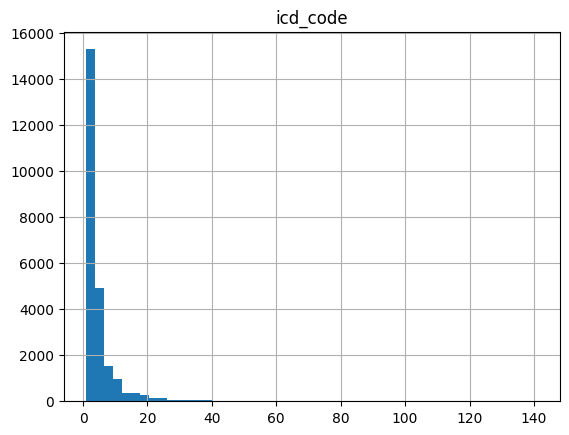

In [ ]:
hfcodecounts.hist(bins=50)

In [ ]:
discharge = pd.read_csv(raw_data_path+'discharge.csv.gz')

In [ ]:
posNotes = positive_cohort.merge(discharge, on='subject_id', how='inner').sort_values(by=['subject_id', 'charttime'],ascending=True).groupby('subject_id').last().reset_index()[['subject_id','text']]

negNotes = negative_cohort.merge(discharge, on='subject_id', how='inner').sort_values(by=['subject_id', 'charttime'],ascending=True).groupby('subject_id').last().reset_index()[['subject_id','text']]

posNotes['label'] = 1
negNotes['label'] = 0
labelled_notes = pd.concat([posNotes, negNotes])
labelled_notes.to_parquet(output_path+'/labelled_notes.parquet')
